# infos

In [ ]:
# Version 1.1

# Notebook d'étude d'un modèle entrainé

### Changelogs :

v1.1 :
- Nettoyage du code pour livraison projet
- Ajout rapport de classification
- Ajout matrice de confusion


v1.0 :
- Chargement du modèle et tests sur images

# Definition des URL

In [44]:
# Vérifier que les chemins soient correct avant toutes opérations
chemin_images = '../../images/'
chemin_csv = '../data/top10.csv'

# Dimensions des images
img_dim = (224,224)
img_shape = (224,224,3)

# Librairies à charger

In [45]:
# Librairies servant à charger le modèle
from tensorflow import keras

# Librairies servant à charger les données
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from collections import Counter
import tensorflow as tf

# Librairies servant à charger les images et les afficher
import requests
import cv2
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
import numpy as np
import matplotlib.pyplot as plt


# Librairies utilisées pour l'évaluation du modèle une fois entrainé
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

# Fonctions

In [46]:
def import_df(chemin_images, chemin_csv, pourcentage_echantillon=0.1):
    '''Importe le fichier csv et construit 2 df :
        - Le DF basé sur le CSV original
        - Un DF echantillon comportant 10% de données aléatoires du DF original
    '''
    
    
    # import du df
    df = pd.read_csv(chemin_csv, low_memory=False)
    print(f"Nombre d'images chargées pour df: {df.shape[0]}")
    print(f"Nb especes dans df: {df['label'].nunique()}")


    # Contruction de l'echantillon
    L = len(df)
    L_ech = int(pourcentage_echantillon * L)
    df_ech = df.sample(n=L_ech, random_state=10)
    df_ech.reset_index(inplace=True, drop=True)
    print(f"Nombre d'images chargées pour df_ech: {df_ech.shape[0]}")
    print(f"Nb especes dans df_ech: {df_ech['label'].nunique()}")

    return df, df_ech

In [47]:
def augment_img(image_path, label):

    '''Modifie les images aléatoirement dans le dataset qui sera soumis au modèle, oversample les classes sous représentées.
       image_path : chemin des images (variable définie en début de notebook),
       label : Variable contenant les classes,
    '''

    img = tf.io.read_file(image_path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.resize(img, img_dim)         # Rappel : img_dim est définie en début de Notebook
    img = preprocess_input(img)

    img = tf.image.random_flip_left_right(img)
    img = tf.image.random_flip_up_down(img)
    img = tf.image.random_brightness(img, max_delta=0.2)
    img = tf.image.random_contrast(img, lower=0.8, upper=1.2)
    img = tf.image.convert_image_dtype(img, tf.float32)
    #img = tf.image.per_image_standardization(img)  
    img = (img - tf.math.reduce_min(img)) / (tf.math.reduce_max(img) - tf.math.reduce_min(img))

    return img, label

In [48]:
def create_tf_dataset(image_path, labels, batch_size, oversample_cls = None):
    '''
    Créé un dataset Tensorflow selon les paramètres précisés. La fonction oversample les classes sous représentées
    image_path : chemin relatif de la variable contenant les images
    labels : variable contenant les labels
    batch_size : taille des batchs
    oversample_cls : Liste contenant les classes à oversampler. Si non précisé, l'oversample sera ignoré
    '''

    image_path = image_path.tolist()  # Convertir les chemins d'images en liste
    labels = labels.tolist()          # Convertir les labels en liste


 # Oversample des classes
    if oversample_cls:
    # Compter le nombre d'exemples par classe
        class_counts = Counter(labels)

    # Calculer le nombre d'exemples à ajouter pour chaque classe à oversampler
        max_count = max(class_counts.values())
        facteurs_oversample = {cls: max_count / count for cls, count in class_counts.items() if cls in oversample_cls}

    # Répéter les exemples des classes à oversampler pour atteindre le nombre maximum
        oversampled_image_paths = []
        oversampled_labels = []
        for img_path, label in zip(image_path, labels):
            facteurs_oversample = facteurs_oversample.get(label, 1.0)
            nb_copies = int(facteurs_oversample)
            for _ in range(nb_copies):
                oversampled_image_paths.append(img_path)
                oversampled_labels.append(label)

        image_path = oversampled_image_paths
        labels = oversampled_labels



    # Construction du Dataset
    dataset = tf.data.Dataset.from_tensor_slices((image_path, labels))
    dataset = dataset.map(augment_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.shuffle(buffer_size=len(image_path))
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

    return dataset

# Chargement du DF

In [49]:
df, df_ech = import_df(chemin_images, chemin_csv)

Nombre d'images chargées pour df: 60481
Nb especes dans df: 10
Nombre d'images chargées pour df_ech: 6048
Nb especes dans df_ech: 10


In [50]:
nom_classes = {
    0: "Agaricales",
    1: "Agaricus",
    2: "Amanita",
    3: "Cortinarius",
    4: "Entoloma",
    5: "Inocybe",
    6: "Mycena",
    7: "Polyporales",
    8: "Psathyrella",
    9: "Russula"
}

# Pipeline TensorFlow

In [51]:
data = df.drop('label', axis=1)
target = df['label']

s = LabelEncoder()
target = s.fit_transform(target) # Encodage de la variable 'label'

# On construit le jeu d'entrainnement. X_temp et y_temps servent pour la construction des jeux de test et validation
X_train, X_temp, y_train, y_temp = train_test_split(data, target, test_size=0.25, random_state=10)

# On split les temp en 50% pour test, 50% pour validation
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=10)

In [52]:
batch_size = 32
# Les datasets sont créés à partir de la fonction create_tf_dataset définie dans la partie 'Fonctions'
ds_test = create_tf_dataset(X_test.image_url, y_test, batch_size)

# Chargement du modèle

In [53]:
nom_model = '../model/gpot_v01_full_tri'
model = keras.models.load_model(nom_model)

In [54]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_2 (KerasLayer)  (None, 1000)              7200312   
                                                                 
 dense_2 (Dense)             (None, 10)                10010     
                                                                 
Total params: 7210322 (27.51 MB)
Trainable params: 10010 (39.10 KB)
Non-trainable params: 7200312 (27.47 MB)
_________________________________________________________________


# Prediction image dataset

In [55]:
# Chargement aléatoire d'une image
random_image_row = df.sample(n=1)  # Selection d'une ligne au hasard dans le df
img_path = random_image_row['image_url'].values[0]  # Génère le chemin correspondant à l'image aléaotire

img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

In [56]:
# Faites une prédiction avec le modèle sur l'image chargée
predictions = model.predict(x)
index_classe_predite = np.argmax(predictions)
nom_classe_predite = nom_classes[index_classe_predite]

1/1 [==============================] - 1s 988ms/step


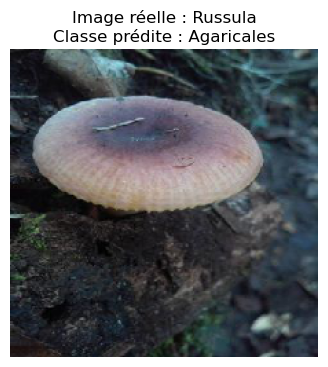

In [57]:
# Obtenir la classe réelle par rapport au chemin de l'image
image_label = df.loc[df['image_url'] == img_path]['label'].values[0]

plt.figure(figsize=(4, 4))
plt.imshow(img)
plt.title(f'Image réelle : {image_label}\nClasse prédite : {nom_classe_predite}')
plt.axis('off')
plt.show()

# Prediction image Web

In [58]:
url = 'https://www.hautesavoiephotos.com/champis/russula-aurea.jpg'

response = requests.get(url)
if response.status_code == 200:
    image_data = response.content
    img_web = cv2.imdecode(np.frombuffer(image_data, np.uint8), cv2.IMREAD_COLOR)
    img_web = cv2.cvtColor(img_web, cv2.COLOR_BGR2RGB)

    w = image.img_to_array(img_web)
    w = np.expand_dims(w, axis=0)
    w = preprocess_input(w)

else:
    print(f"La requête a échoué avec le code d'état {response.status_code}")

In [59]:
# Faites une prédiction avec le modèle sur l'image web chargée
predictions_web = model.predict(w)
index_classe_web = np.argmax(predictions_web)
nom_classe_predite = nom_classes[index_classe_web]

1/1 [==============================] - 1s 1s/step


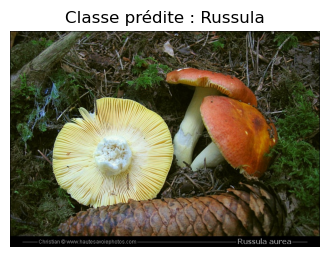

In [60]:
# Obtenir la classe réelle par rapport au chemin de l'image
image_label = df.loc[df['image_url'] == img_path]['label'].values[0]

plt.figure(figsize=(4, 4))
plt.imshow(img_web)
plt.title(f'Classe prédite : {nom_classe_predite}')
plt.axis('off')
plt.show()

# Rapports d'évaluation modèle

### Accuracy sur jeu de test

In [61]:
test_loss, test_accuracy = model.evaluate(ds_test)
print("Test accuracy:", test_accuracy)

237/237 [==============================] - 306s 1s/step - loss: 1.5162 - accuracy: 0.5035
Test accuracy: 0.5035048127174377


### Predictions sur le jeu de test

In [62]:
y_pred_test = model.predict(ds_test)
y_pred_test_classes = y_pred_test.argmax(axis=1)

237/237 [==============================] - 337s 1s/step


### Rapport de classification

In [63]:
report = classification_report(y_test, y_pred_test_classes, target_names=[nom_classes[i] for i in range(10)])
print(report)

              precision    recall  f1-score   support

  Agaricales       0.19      0.21      0.20      1383
    Agaricus       0.06      0.09      0.08       529
     Amanita       0.07      0.06      0.07       620
 Cortinarius       0.13      0.08      0.10       889
    Entoloma       0.06      0.09      0.08       493
     Inocybe       0.06      0.02      0.03       526
      Mycena       0.08      0.10      0.09       610
 Polyporales       0.12      0.11      0.12       889
 Psathyrella       0.09      0.10      0.09       655
     Russula       0.12      0.13      0.12       967

    accuracy                           0.11      7561
   macro avg       0.10      0.10      0.10      7561
weighted avg       0.11      0.11      0.11      7561



### Matrice de confusion

In [64]:
y_pred_classes_names = [nom_classes[i] for i in y_pred_test_classes]


# Créer un DataFrame pour les classes réelles et prédites
confusion_df = pd.DataFrame({'Classe': [nom_classes[i] for i in y_test], 'Prediction': y_pred_classes_names})

# Générer la matrice de confusion
matrice_confusion = pd.crosstab(confusion_df['Classe'], confusion_df['Prediction'], rownames=['Classe'], colnames=['Prediction'])

print(matrice_confusion)

Prediction   Agaricales  Agaricus  Amanita  Cortinarius  Entoloma  Inocybe  \
Classe                                                                       
Agaricales          288       137       91           85       134       27   
Agaricus             98        48       41           42        48       12   
Amanita             130        78       38           42        55       12   
Cortinarius         187        93       57           72        84       21   
Entoloma             90        49       39           25        45       13   
Inocybe             120        58       36           40        44       10   
Mycena              118        59       50           45        71       12   
Polyporales         178        73       63           73        75       16   
Psathyrella         140        68       40           60        54       14   
Russula             207        82       69           69        90       22   

Prediction   Mycena  Polyporales  Psathyrella  Russula  
Classe

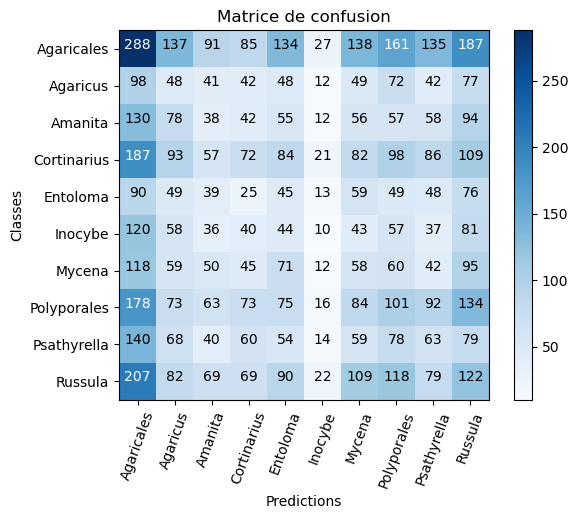

In [65]:
import itertools  

matrice = confusion_matrix(y_test, y_pred_test_classes)
classes = [nom_classes[i] for i in range(10)]

plt.figure()

plt.imshow(matrice, interpolation='nearest',cmap='Blues')
plt.title("Matrice de confusion")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation = 70)
plt.yticks(tick_marks, classes)

for i, j in itertools.product(range(matrice.shape[0]), range(matrice.shape[1])):
    plt.text(j, i, matrice[i, j],
             horizontalalignment = "center",
             color = "white" if matrice[i, j] > (matrice.max() / 2) else "black")

plt.ylabel('Classes')
plt.xlabel('Predictions')
plt.show()